In [96]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx


from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance


 
import logging
from collections import OrderedDict
from math import fsum
import numpy as np
from docplex.mp.constants import ComparisonType
from docplex.mp.model import Model
from qiskit.quantum_info import Pauli
from qiskit.aqua import Operator, AquaError

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

from qiskit import IBMQ
# provider = IBMQ.load_account()

def get_qubitops(mdl, auto_penalty=False, default_penalty=1e5):
    """ Generate Ising Hamiltonian from a model of DOcplex.
    Args:
        mdl (docplex.mp.model.Model): A model of DOcplex for a optimization problem.
        auto_penalty (bool): If true, the penalty coefficient is automatically defined by "_auto_define_penalty()".
        default_penalty (float): The default value of the penalty coefficient for the constraints.
            This value is used if "auto_penalty" is False.
    Returns:
        operator.Operator, float: operator for the Hamiltonian and a
        constant shift for the obj function.
    """
    #_validate_input_model(mdl)
    # set the penalty coefficient by _auto_define_penalty() or manually.
    if auto_penalty:
        penalty = _auto_define_penalty(mdl, default_penalty)
    else:
        penalty = default_penalty
    # set a sign corresponding to a maximized or minimized problem.
    # sign == 1 is for minimized problem. sign == -1 is for maximized problem.
    sign = 1
    if mdl.is_maximized():
        sign = -1
    # assign variables of the model to qubits.
    qd = {}
    index = 0
    for i in mdl.iter_variables():
        if i in qd:
            continue
        qd[i] = index
        index += 1
    # initialize Hamiltonian.
    num_nodes = len(qd)
    pauli_list = []
    shift = 0
    zero = np.zeros(num_nodes, dtype=np.bool)
    # convert a constant part of the object function into Hamiltonian.
    shift += mdl.get_objective_expr().get_constant() * sign
    # convert linear parts of the object function into Hamiltonian.
    l_itr = mdl.get_objective_expr().iter_terms()
    for j in l_itr:
        zp = np.zeros(num_nodes, dtype=np.bool)
        index = qd[j[0]]
        weight = j[1] * sign / 2
        zp[index] = True
        pauli_list.append([-weight, Pauli(zp, zero)])
        shift += weight
    # convert quadratic parts of the object function into Hamiltonian.
    q_itr = mdl.get_objective_expr().iter_quads()
    for i in q_itr:
        index1 = qd[i[0][0]]
        index2 = qd[i[0][1]]
        weight = i[1] * sign / 4
        if index1 == index2:
            shift += weight
        else:
            zp = np.zeros(num_nodes, dtype=np.bool)
            zp[index1] = True
            zp[index2] = True
            pauli_list.append([weight, Pauli(zp, zero)])
        zp = np.zeros(num_nodes, dtype=np.bool)
        zp[index1] = True
        pauli_list.append([-weight, Pauli(zp, zero)])
        zp = np.zeros(num_nodes, dtype=np.bool)
        zp[index2] = True
        pauli_list.append([-weight, Pauli(zp, zero)])
        shift += weight
    # convert constraints into penalty terms.
    for constraint in mdl.iter_constraints():
        constant = constraint.right_expr.get_constant()
        # constant parts of penalty*(Constant-func)**2: penalty*(Constant**2)
        shift += penalty * constant ** 2
        # linear parts of penalty*(Constant-func)**2: penalty*(-2*Constant*func)
        for l in constraint.left_expr.iter_terms():
            zp = np.zeros(num_nodes, dtype=np.bool)
            index = qd[l[0]]
            weight = l[1]
            zp[index] = True
            pauli_list.append([penalty * constant * weight, Pauli(zp, zero)])
            shift += -penalty * constant * weight
        # quadratic parts of penalty*(Constant-func)**2: penalty*(func**2)
        for l in constraint.left_expr.iter_terms():
            for l2 in constraint.left_expr.iter_terms():
                index1 = qd[l[0]]
                index2 = qd[l2[0]]
                weight1 = l[1]
                weight2 = l2[1]
                penalty_weight1_weight2 = penalty * weight1 * weight2 / 4
                if index1 == index2:
                    shift += penalty_weight1_weight2
                else:
                    zp = np.zeros(num_nodes, dtype=np.bool)
                    zp[index1] = True
                    zp[index2] = True
                    print([-penalty_weight1_weight2, Pauli(zp, zero)])
                    pauli_list.append([penalty_weight1_weight2, Pauli(zp, zero)])
                zp = np.zeros(num_nodes, dtype=np.bool)
                zp[index1] = True
                pauli_list.append([-penalty_weight1_weight2, Pauli(zp, zero)])
                zp = np.zeros(num_nodes, dtype=np.bool)
                zp[index2] = True
                pauli_list.append([-penalty_weight1_weight2, Pauli(zp, zero)])
                
                shift += penalty_weight1_weight2
    # Remove paulis whose coefficients are zeros.
    qubitOp = Operator(paulis=pauli_list)
    qubitOp.zeros_coeff_elimination()
    return qubitOp, shift


{(0, 1): Text(0.03703625196102536, 0.49267652500591835, '0.075'),
 (0, 2): Text(-0.046996303736588155, -0.2537665116600932, '0.082'),
 (0, 3): Text(0.16755290509573387, 0.1150465298080354, '0.04'),
 (0, 4): Text(-0.6712035733399144, -0.12087200874616372, '0.098'),
 (1, 2): Text(0.3324470949042661, 0.08352032374069396, '0.034'),
 (1, 3): Text(0.5469963037365881, 0.4523333652088225, '0.096'),
 (1, 4): Text(-0.2917601746990602, 0.21641482665462342, '0.003'),
 (2, 3): Text(0.4629637480389746, -0.294109671457189, '0.046'),
 (2, 4): Text(-0.3757927303966737, -0.5300282100113881, '0.014'),
 (3, 4): Text(-0.16124352156435168, -0.16121516854325954, '0.031')}

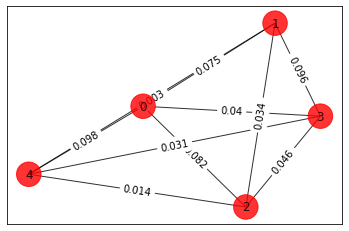

In [210]:
n=5
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[]
for i in range(n):
    for j in range(i+1,n):
        elist.append((i,j,0.001*np.random.randint(1,100)))
# tuple is (i,j,weight) where (i,j) is the edge
                                         
G.add_weighted_edges_from(elist)
colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [211]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight'] 
print(w)

[[0.    0.075 0.082 0.04  0.098]
 [0.075 0.    0.034 0.096 0.003]
 [0.082 0.034 0.    0.046 0.014]
 [0.04  0.096 0.046 0.    0.031]
 [0.098 0.003 0.014 0.031 0.   ]]


In [215]:
from docplex.mp.model import Model
from qiskit.aqua.translators.ising import docplex
m=3
# Create an instance of a model and variables.
mdl = Model(name='qmd')
x = {i: mdl.binary_var(name='x_{0}'.format(i)) for i in range(n)}
# Object function
qmd_func = mdl.sum(w[i,j]* x[i] * ( 1 - x[j] ) for i in range(n) for j in range(n))
mdl.minimize(qmd_func)

# Constraints
mdl.add_constraint(mdl.sum(x[p] for p in range(n)) == m)


print(mdl.export_to_string());
qubitOp, offset = docplex.get_qubitops(mdl);

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: qmd

Minimize
 obj: 0.295000000000 x_0 + 0.208000000000 x_1 + 0.176000000000 x_2
      + 0.213000000000 x_3 + 0.146000000000 x_4 + [ - 0.300000000000 x_0*x_1
      - 0.328000000000 x_0*x_2 - 0.160000000000 x_0*x_3 - 0.392000000000 x_0*x_4
      - 0.136000000000 x_1*x_2 - 0.384000000000 x_1*x_3 - 0.012000000000 x_1*x_4
      - 0.184000000000 x_2*x_3 - 0.056000000000 x_2*x_4 - 0.124000000000 x_3*x_4
      ]/2
Subject To
 c1: x_0 + x_1 + x_2 + x_3 + x_4 = 3

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4
End



In [216]:
#print(qubitOp.paulis)

[1. 0. 1. 0. 1.]
objective: 0.2290000000000001
4.873499999999999 -4.644499999999999


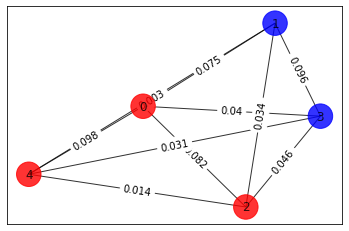

In [217]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()

"""
algorithm_cfg = {
    'name': 'ExactEigensolver',
}

params = {
    'problem': {'name': 'ising'},
    'algorithm': algorithm_cfg
}
result = run_algorithm(params,algo_input)
"""
x = docplex.sample_most_likely(result['eigvecs'][0]);
print(x)
print('objective:', result['energy'] + offset)
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels);

print(offset, result['energy'])

[1 0 1 0 1]
objective: 0.24930273437500006
4.873499999999999 -4.624197265624999


{(0, 1): Text(0.03703625196102536, 0.49267652500591835, '0.075'),
 (0, 2): Text(-0.046996303736588155, -0.2537665116600932, '0.082'),
 (0, 3): Text(0.16755290509573387, 0.1150465298080354, '0.04'),
 (0, 4): Text(-0.6712035733399144, -0.12087200874616372, '0.098'),
 (1, 2): Text(0.3324470949042661, 0.08352032374069396, '0.034'),
 (1, 3): Text(0.5469963037365881, 0.4523333652088225, '0.096'),
 (1, 4): Text(-0.2917601746990602, 0.21641482665462342, '0.003'),
 (2, 3): Text(0.4629637480389746, -0.294109671457189, '0.046'),
 (2, 4): Text(-0.3757927303966737, -0.5300282100113881, '0.014'),
 (3, 4): Text(-0.16124352156435168, -0.16121516854325954, '0.031')}

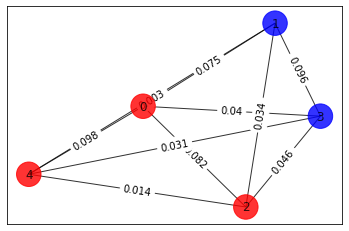

In [218]:
# run quantum algorithm with shots

seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

"""update params in the previous cell
params['backend']['provider'] = 'qiskit.BasicAer'
params['backend']['name'] = 'qasm_simulator'
params['backend']['shots'] = 1024
result = run_algorithm(params,algo_input)
"""
x = docplex.sample_most_likely(result['eigvecs'][0])
print(x)
print('objective:', result['energy'] + offset)
print(offset, result['energy'])
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [172]:
from qiskit.providers.ibmq import least_busy
from qiskit import IBMQ
IBMQ.save_account('a99b791175c2434db467f99104b72a942c22da1e7d705ceaf66d4b7709d49e40e3aaa309064aea044a09e752ca9173c61fd3f917b859af291d700f0761ff802d')


//anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/credentials/configrc.py:130: UserWarning: Credentials already present. Set overwrite=True to overwrite.
  warnings.warn('Credentials already present. '


In [221]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
backend_lb = least_busy(provider.backends(simulator=False, operational=True))
print("Least busy backend: ", backend_lb)

Least busy backend:  ibmq_vigo


The skip Qobj validation does not work for IBMQ provider. Disable it.
FAILURE: job id: 5da17ba051516a0019aa28c5, status: 'FAIL_TO_GET_STATUS' Terra job error: '520 Server Error: Origin Error for url: https://api.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs/5da17ba051516a0019aa28c5/status?access_token=...'
FAILURE: job id: 5da17ba051516a0019aa28c5, status: 'FAIL_TO_GET_STATUS' Terra job error: '520 Server Error: Origin Error for url: https://api.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs/5da17ba051516a0019aa28c5/status?access_token=...'


[0 1 1 0 1]
objective: 4.0128046875


{(0, 1): Text(0.03703625196102536, 0.49267652500591835, '0.075'),
 (0, 2): Text(-0.046996303736588155, -0.2537665116600932, '0.082'),
 (0, 3): Text(0.16755290509573387, 0.1150465298080354, '0.04'),
 (0, 4): Text(-0.6712035733399144, -0.12087200874616372, '0.098'),
 (1, 2): Text(0.3324470949042661, 0.08352032374069396, '0.034'),
 (1, 3): Text(0.5469963037365881, 0.4523333652088225, '0.096'),
 (1, 4): Text(-0.2917601746990602, 0.21641482665462342, '0.003'),
 (2, 3): Text(0.4629637480389746, -0.294109671457189, '0.046'),
 (2, 4): Text(-0.3757927303966737, -0.5300282100113881, '0.014'),
 (3, 4): Text(-0.16124352156435168, -0.16121516854325954, '0.031')}

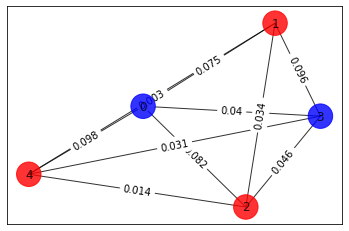

In [223]:
# run quantum algorithm with shots

seed = 10598

spsa = SPSA(max_trials=50)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

#backend = BasicAer.get_backend_lb('ibmq_vigo')
quantum_instance = QuantumInstance(backend_lb, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

"""update params in the previous cell
params['backend']['provider'] = 'qiskit.BasicAer'
params['backend']['name'] = 'qasm_simulator'
params['backend']['shots'] = 1024
result = run_algorithm(params,algo_input)
"""
x = docplex.sample_most_likely(result['eigvecs'][0])
print(x)
print('objective:', result['energy'] + offset)
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [198]:
print (offset)

100.10899999999998


In [199]:
print(result['energy'])

-52.32297851562501


In [ ]:
# run quantum algorithm with shots

seed = 10598

spsa = SPSA(max_trials=100)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

#backend = BasicAer.get_backend_lb('ibmq_vigo')
quantum_instance = QuantumInstance(backend_lb, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

"""update params in the previous cell
params['backend']['provider'] = 'qiskit.BasicAer'
params['backend']['name'] = 'qasm_simulator'
params['backend']['shots'] = 1024
result = run_algorithm(params,algo_input)
"""
x = docplex.sample_most_likely(result['eigvecs'][0])
print(x)
print('objective:', result['energy'] + offset)
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

The skip Qobj validation does not work for IBMQ provider. Disable it.
FAILURE: job id: 5da1884b0dfc860018b49ffd, status: 'FAIL_TO_GET_STATUS' Terra job error: '520 Server Error: Origin Error for url: https://api.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs/5da1884b0dfc860018b49ffd/status?access_token=...'
FAILURE: job id: 5da1884b0dfc860018b49ffd, status: 'FAIL_TO_GET_STATUS' Terra job error: '520 Server Error: Origin Error for url: https://api.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs/5da1884b0dfc860018b49ffd/status?access_token=...'
FAILURE: job id: 5da189ab0b25ce0018e23bf8, status: 'FAIL_TO_GET_STATUS' Terra job error: '520 Server Error: Origin Error for url: https://api.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs/5da189ab0b25ce0018e23bf8/status?access_token=...'
FAILURE: job id: 5da189ab0b25ce0018e23bf8, status: 'FAIL_TO_GET_STATUS' Terra job error: '520 Server Error: Origin Error for url: